In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

import time
import numpy as np
import matplotlib.pyplot as plt

# 1. Dataset

In [2]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']
###
tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in train_examples), target_vocab_size=2**13)

tokenizer_pt = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_examples), target_vocab_size=2**13)
###
BUFFER_SIZE = 20000
BATCH_SIZE = 64
MAX_LENGTH = 40
###
def encode(lang1, lang2):
  lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(
      lang1.numpy()) + [tokenizer_pt.vocab_size+1]

  lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
      lang2.numpy()) + [tokenizer_en.vocab_size+1]
  
  return lang1, lang2
###
def tf_encode(pt, en):
  result_pt, result_en = tf.py_function(encode, [pt, en], [tf.int64, tf.int64])
  result_pt.set_shape([None])
  result_en.set_shape([None])

  return result_pt, result_en

###
def filter_max_length(x, y, max_length=MAX_LENGTH):
  return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)
  
train_dataset = train_examples.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
# cache the dataset to memory to get a speedup while reading from it.
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)


val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE)

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteQI65DG/ted_hrlr_translate-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteQI65DG/ted_hrlr_translate-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteQI65DG/ted_hrlr_translate-test.tfrecord


Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


In [3]:
for x, y in train_dataset.take(5):
    print(x.shape)
    print(y.shape)
    print("Break")

(64, 37)
(64, 40)
Break
(64, 40)
(64, 37)
Break
(64, 38)
(64, 40)
Break
(64, 37)
(64, 37)
Break
(64, 38)
(64, 40)
Break


In [3]:
tokenizer_en.

8214

# 2. Explaination

## Positional encoding

Since this model doesn't contain any recurrence or convolution, positional encoding is added to give the model some information about the relative position of the words in the sentence. 

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of words in a sentence. So after adding the positional encoding, words will be closer to each other based on the *similarity of their meaning and their position in the sentence*, in the d-dimensional space.

See the notebook on [positional encoding](https://github.com/tensorflow/examples/blob/master/community/en/position_encoding.ipynb) to learn more about it. The formula for calculating the positional encoding is as follows:

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [ ]:
def positional_encoding(pos, d_model):
    def get_angle(pos, i, d_model):
        return pos / np.power(10000, 2 * (i // 4) / np.float32(d_model))
    angles = get_angle(np.arange(pos)[:, np.newaxis],
                       np.arange(d_model)[np.newaxis, :],
                       d_model)
    angles[:, ::2] = np.sin(angles[:, ::2])
    angles[:, 1::2] = np.cos(angles[:, 1::2])
    return angles[np.newaxis]

(1, 4000, 2048)


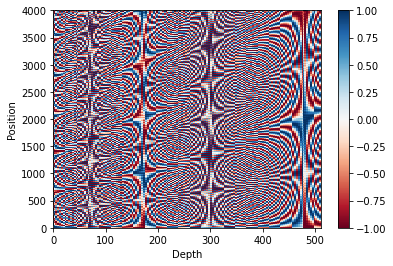

In [ ]:
pos_encoding = positional_encoding(4000, 2048)

print(pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [ ]:
positional_encoding(5, 10)

array([[[ 0.        ,  1.        ,  0.        ,  1.        ,
          0.        ,  1.        ,  0.        ,  1.        ,
          0.        ,  1.        ],
        [ 0.84147098,  0.54030231,  0.15782664,  0.98746684,
          0.02511622,  0.99968454,  0.00398106,  0.99999208,
          0.00063096,  0.9999998 ],
        [ 0.90929743, -0.41614684,  0.31169715,  0.9501815 ,
          0.0502166 ,  0.99873835,  0.00796206,  0.9999683 ,
          0.00126191,  0.9999992 ],
        [ 0.14112001, -0.9899925 ,  0.45775455,  0.88907861,
          0.07528529,  0.99716204,  0.01194293,  0.99992868,
          0.00189287,  0.99999821],
        [-0.7568025 , -0.65364362,  0.59233773,  0.80568978,
          0.10030649,  0.99495659,  0.01592361,  0.99987321,
          0.00252383,  0.99999682]]])

## Masking

In [ ]:
def padding_mask(seq):
    return tf.cast(tf.math.equal(seq, 0)[:, tf.newaxis, tf.newaxis, :], tf.float32)

def lookahead_mask(size):
    return 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)

x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
print(padding_mask(x))

x = tf.random.uniform((1, 3))
temp = lookahead_mask(x.shape[1])
print(temp)

tf.Tensor(
[[[[0. 0. 1. 1. 0.]]]


 [[[0. 0. 0. 1. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(3, 1, 1, 5), dtype=float32)
tf.Tensor(
[[0. 1. 1.]
 [0. 0. 1.]
 [0. 0. 0.]], shape=(3, 3), dtype=float32)


## Transformer Diagram

<img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png" width="600" alt="transformer">

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


Multi-head attention consists of four parts:
*    Linear layers and split into heads.
*    Scaled dot-product attention.
*    Concatenation of heads.
*    Final linear layer.

Scaled Dot Product Attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/scaled_attention.png" width="500" alt="scaled_dot_product_attention">

The attention function used by the transformer takes three inputs: Q (query), K (key), V (value). The equation used to calculate the attention weights is:

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

The dot-product attention is scaled by a factor of square root of the depth. This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax. 

For example, consider that `Q` and `K` have a mean of 0 and variance of 1. Their matrix multiplication will have a mean of 0 and variance of `dk`. Hence, *square root of `dk`* is used for scaling (and not any other number) because the matmul of `Q` and `K` should have a mean of 0 and variance of 1, and you get a gentler softmax.

The mask is multiplied with -1e9 (close to negative infinity). This is done because the mask is summed with the scaled matrix multiplication of Q and K and is applied immediately before a softmax. The goal is to zero out these cells, and large negative inputs to softmax are near zero in the output.

In [ ]:
def scaled_dot_product_attention(q, k, v, mask=None):
        matmul = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(k.shape[-1], tf.float32)
        scaled = matmul / tf.math.sqrt(dk)
        if mask:
            scaled += (mask * -1e9)
        attention_weights = tf.nn.softmax(scaled, -1)
        output = tf.matmul(attention_weights, v)
        return output, attention_weights

In [ ]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)

np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


## Learning rate schedule

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$


In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    self.d_model = tf.cast(d_model, tf.float32)
    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

# 3. Into the code

**Creating Multi Head Attention Layer**

In [4]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        assert self.d_model % self.num_heads == 0
        self.depth = self.d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        self.dense = tf.keras.layers.Dense(d_model)

    def split_head(self, x):
        # x.shape = batch_size, seq_len, d_model
        # => split to batch_size, num_heads, seq_len, depth
        x = tf.reshape(x, (x.shape[0], x.shape[1], self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def scaledDot_product(self, q, k, v, mask):
        score = tf.matmul(q, k, transpose_b=True)
        score = score / tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        if mask is not None:
            score += (mask*-1e9)
        attention_weights = tf.nn.softmax(score, -1)
        output = tf.matmul(attention_weights, v)
        #Concat output
        output = tf.reshape(tf.transpose(output, perm=[0, 2, 1, 3]),
                            (output.shape[0], output.shape[2], self.d_model))
        return output, attention_weights

    def call(self, x, q, mask):
        q = self.split_head(self.wq(q))
        k = self.split_head(self.wk(x))
        v = self.split_head(self.wv(x))

        output, attention_weights = self.scaledDot_product(q, k, v, mask)
        return output, attention_weights

**Encoding Layer**

In [5]:
class EncodingLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, rate):
        super(EncodingLayer, self).__init__()
        # MultiHeadAttention
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.mha_drop = tf.keras.layers.Dropout(rate)
        self.mha_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        #Feed Forward
        self.w1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w2 = tf.keras.layers.Dense(d_model)
        self.ff_drop = tf.keras.layers.Dropout(rate)
        self.ff_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    def call(self, x, padding_mask, training):
        #MultiHeadAttention
        mha_output, _ = self.mha(x, x, padding_mask)
        mha_output = self.mha_drop(mha_output, training=training)
        mha_output = self.mha_norm(mha_output + x)
        #Feed Forward
        ff_output = self.w2(self.w1(mha_output))
        ff_output = self.ff_drop(ff_output, training=training)
        ff_output = self.ff_norm(ff_output + mha_output)

        return ff_output

In [6]:
class DecodingLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, rate):
        super(DecodingLayer, self).__init__()
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha1_drop = tf.keras.layers.Dropout(rate)
        self.mha1_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.mha2 = MultiHeadAttention(d_model, num_heads)
        self.mha2_drop = tf.keras.layers.Dropout(rate)
        self.mha2_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.w1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w2 = tf.keras.layers.Dense(d_model)
        self.ff_drop = tf.keras.layers.Dropout(rate)
        self.ff_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    def call(self, x, enc_output, lookahead_mask, padding_mask, training):
        mha1_output, _ = self.mha1(x, x, lookahead_mask)
        mha1_output = self.mha1_drop(mha1_output, training=training)
        mha1_output = self.mha1_norm(mha1_output + x)

        mha2_output, attention_weights = self.mha2(enc_output, mha1_output, padding_mask)
        mha2_output = self.mha2_drop(mha2_output, training=training)
        mha2_output = self.mha2_norm(mha2_output + mha1_output)

        ff_output = self.w2(self.w1(mha2_output))
        ff_output = self.ff_drop(ff_output, training=training)
        ff_output = self.ff_norm(ff_output + mha2_output)

        return ff_output, attention_weights

In [7]:
class Transformer(tf.keras.Model):
    def __init__(self, d_model, num_heads, num_layers, d_ff, enc_vocab_size,
                 dec_vocab_size, enc_pe, dec_pe, rate=0.1):
        super(Transformer, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        #Encoding Layers
        self.enc_embedding = tf.keras.layers.Embedding(input_dim=enc_vocab_size,
                                                       output_dim=d_model)
        self.enc_drop = tf.keras.layers.Dropout(rate)
        self.enc_pos = self.positional_encoding(enc_pe)
        self.encoding_layers = [EncodingLayer(d_model, num_heads, d_ff, rate) \
                                for _ in range(self.num_layers)]
        #Decoding Layers
        self.dec_embedding = tf.keras.layers.Embedding(input_dim=dec_vocab_size,
                                                       output_dim=d_model)
        self.dec_drop = tf.keras.layers.Dropout(rate)
        self.dec_pos = self.positional_encoding(dec_pe)
        self.decoding_layers = [DecodingLayer(d_model, num_heads, d_ff, rate) \
                                for _ in range(self.num_layers)]
        #Feed Forward
        self.dense = tf.keras.layers.Dense(dec_vocab_size)
    
    def positional_encoding(self, pos):
        def get_angles(pos, i, d_model):
            return pos / np.power(10000, 2*(i)/ np.float32(d_model))

        angles = get_angles(np.arange(pos)[:, np.newaxis],
                            np.arange(self.d_model)[np.newaxis, :],
                            self.d_model)
        angles[:, 0::2] = np.sin(angles[:, 0::2])
        angles[:, 1::2] = np.cos(angles[:, 1::2])
        return angles[np.newaxis]
    
    def padding_mask(self, input):
        mask = tf.math.equal(input, 0)

    def call(self, input, target, mask=True, training=True):
        #Creating masks
        if mask:
            padding_mask = tf.cast(tf.math.equal(input, 0), 
                                   tf.float32)[:, tf.newaxis, tf.newaxis, :]
            lookahead_mask = 1 - tf.linalg.band_part(
                tf.ones((target.shape[1], target.shape[1])), -1, 0)
        #Encoding layers
        enc_embedded = self.enc_embedding(input)
        enc_embedded *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        enc_embedded += self.enc_pos[:, :enc_embedded.shape[1], :]
        enc_output = self.enc_drop(enc_embedded)
        for i in range(self.num_layers):
            enc_output = self.encoding_layers[i](enc_output, 
                                                 padding_mask, 
                                                 training)
        #Decoding layers
        dec_embedded = self.dec_embedding(target)
        dec_embedded *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        dec_embedded += self.dec_pos[:, :dec_embedded.shape[1], :]
        dec_output = self.dec_drop(dec_embedded)
        attention = []
        for i in range(self.num_layers):
            dec_output, weights = self.decoding_layers[i](dec_output, 
                                                          enc_output,
                                                          lookahead_mask,
                                                          padding_mask, 
                                                          training)
            attention.append(weights)
        #Feed Forward
        output = self.dense(dec_output)
        return output, attention     

In [8]:
sample_transformer =Transformer(d_model=512, num_heads=8, num_layers=2, d_ff=2048,
                                enc_vocab_size=8500,dec_vocab_size=8000, 
                                enc_pe=10000, dec_pe=6000, rate=0.1)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, mask=True, training=False)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

In [9]:
num_layers = 4
d_model = 128
d_ff = 512
head_nums = 8

input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
vocab_size = [input_vocab_size, target_vocab_size]
dropout_rate = 0.1

transformer = Transformer(d_model=d_model, 
                          num_heads=head_nums, 
                          num_layers=num_layers,
                          d_ff=d_ff,
                          enc_vocab_size=input_vocab_size, 
                          dec_vocab_size=target_vocab_size, 
                          enc_pe=input_vocab_size, 
                          dec_pe=target_vocab_size, 
                          rate=0.1)

In [10]:
#Learning rate
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
    
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

#Loss
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')
#Checkpoint
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [11]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

#@tf.function(input_signature=train_step_signature)
@tf.function
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
  
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, mask=True, training=True)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
    train_loss(loss)
    train_accuracy(tar_real, predictions)

In [12]:
for epoch in range(20):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 550 Loss 7.4895 Accuracy 0.0362
Epoch 1 Batch 600 Loss 7.3685 Accuracy 0.0398
Epoch 1 Batch 650 Loss 7.2495 Accuracy 0.0435
Epoch 1 Batch 700 Loss 7.1349 Accuracy 0.0473
Epoch 1 Loss 7.1305 Accuracy 0.0474
Time taken for 1 epoch: 357.16938877105713 secs

Epoch 2 Batch 0 Loss 5.4022 Accuracy 0.1018
Epoch 2 Batch 50 Loss 5.4892 Accuracy 0.1038
Epoch 2 Batch 100 Loss 5.4423 Accuracy 0.1057
Epoch 2 Batch 150 Loss 5.3849 Accuracy 0.1082
Epoch 2 Batch 200 Loss 5.3287 Accuracy 0.1109
Epoch 2 Batch 250 Loss 5.2854 Accuracy 0.1128
Epoch 2 Batch 300 Loss 5.2463 Accuracy 0.1146
Epoch 2 Batch 350 Loss 5.2104 Accuracy 0.1164
Epoch 2 Batch 400 Loss 5.1759 Accuracy 0.1178
Epoch 2 Batch 450 Loss 5.1392 Accuracy 0.1194
Epoch 2 Batch 500 Loss 5.1092 Accuracy 0.1208
Epoch 2 Batch 550 Loss 5.0825 Accuracy 0.1222
Epoch 2 Batch 600 Loss 5.0549 Accuracy 0.1234
Epoch 2 Batch 650 Loss 5.0299 Accuracy 0.1245
Epoch 2 Batch 700 Loss 5.0047 Accuracy 0.1257
Epoch 2 Loss 5.0038 Accuracy 0.1258
Time tak

In [18]:
def evaluate(inp_sentence):
  start_token = [tokenizer_pt.vocab_size]
  end_token = [tokenizer_pt.vocab_size + 1]
  
  # inp sentence is portuguese, hence adding the start and end token
  inp_sentence = start_token + tokenizer_pt.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)
  
  # as the target is english, the first word to the transformer should be the
  # english start token.
  decoder_input = [tokenizer_en.vocab_size]
  output = tf.expand_dims(decoder_input, 0)
    
  for i in range(MAX_LENGTH):
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input, 
                                                 output, 
                                                 mask=True, 
                                                 training=False)
    print("pred shape", predictions.shape)
    print("output shape", output.shape)
    # select the last word from the seq_len dimension
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # return the result if the predicted_id is equal to the end token
    if predicted_id == tokenizer_en.vocab_size+1:
      return tf.squeeze(output, axis=0), attention_weights
    
    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0), attention_weights

In [14]:
def plot_attention_weights(attention, sentence, result, layer):
    fig = plt.figure(figsize=(16, 8))
    
    sentence = tokenizer_pt.encode(sentence)
    
    attention = tf.squeeze(attention[layer-1], axis=0)
    
    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head+1)
        
        # plot the attention weights
        ax.matshow(attention[head][:-1, :], cmap='viridis')

        fontdict = {'fontsize': 10}
        
        ax.set_xticks(range(len(sentence)+2))
        ax.set_yticks(range(len(result)))
        
        ax.set_ylim(len(result)-1.5, -0.5)
            
        ax.set_xticklabels(
            ['<start>']+[tokenizer_pt.decode([i]) for i in sentence]+['<end>'], 
            fontdict=fontdict, rotation=90)
        
        ax.set_yticklabels([tokenizer_en.decode([i]) for i in result 
                            if i < tokenizer_en.vocab_size], 
                        fontdict=fontdict)
        
        ax.set_xlabel('Head {}'.format(head+1))
    
    plt.tight_layout()
    plt.show()

def translate(sentence, plot):
    result, attention_weights = evaluate(sentence)
    
    predicted_sentence = tokenizer_en.decode([i for i in result 
                                                if i < tokenizer_en.vocab_size])  

    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(predicted_sentence))
    
    if plot is not None:
        plot_attention_weights(attention_weights, sentence, result, plot)

pred shape (1, 1, 8089)
output shape (1, 1)
pred shape (1, 2, 8089)
output shape (1, 2)
pred shape (1, 3, 8089)
output shape (1, 3)
pred shape (1, 4, 8089)
output shape (1, 4)
pred shape (1, 5, 8089)
output shape (1, 5)
pred shape (1, 6, 8089)
output shape (1, 6)
pred shape (1, 7, 8089)
output shape (1, 7)
pred shape (1, 8, 8089)
output shape (1, 8)
pred shape (1, 9, 8089)
output shape (1, 9)
pred shape (1, 10, 8089)
output shape (1, 10)
pred shape (1, 11, 8089)
output shape (1, 11)
pred shape (1, 12, 8089)
output shape (1, 12)
Input: este é um problema que temos que resolver.
Predicted translation: this is a problem that we have to solve it .


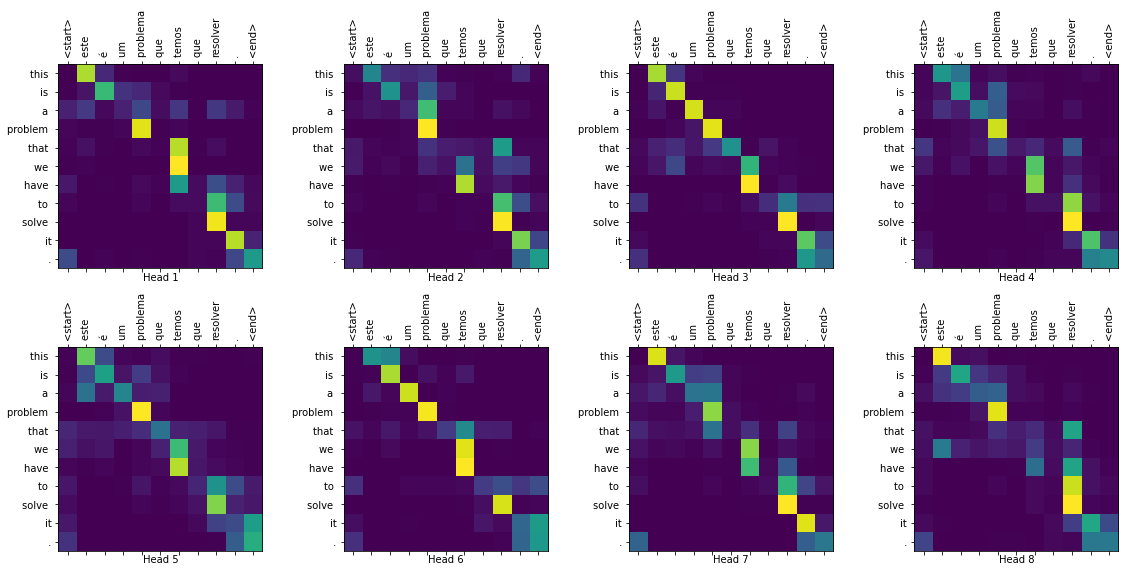

Real translation: this is a problem we have to solve .


In [19]:
translate("este é um problema que temos que resolver.", plot=4)
print ("Real translation: this is a problem we have to solve .")

pred shape (1, 1, 8089)
output shape (1, 1)
pred shape (1, 2, 8089)
output shape (1, 2)
pred shape (1, 3, 8089)
output shape (1, 3)
pred shape (1, 4, 8089)
output shape (1, 4)
pred shape (1, 5, 8089)
output shape (1, 5)
pred shape (1, 6, 8089)
output shape (1, 6)
pred shape (1, 7, 8089)
output shape (1, 7)
pred shape (1, 8, 8089)
output shape (1, 8)
pred shape (1, 9, 8089)
output shape (1, 9)
pred shape (1, 10, 8089)
output shape (1, 10)
pred shape (1, 11, 8089)
output shape (1, 11)
pred shape (1, 12, 8089)
output shape (1, 12)
Input: este é um problema que temos que resolver.
Predicted translation: this is a problem that we have to solve it .


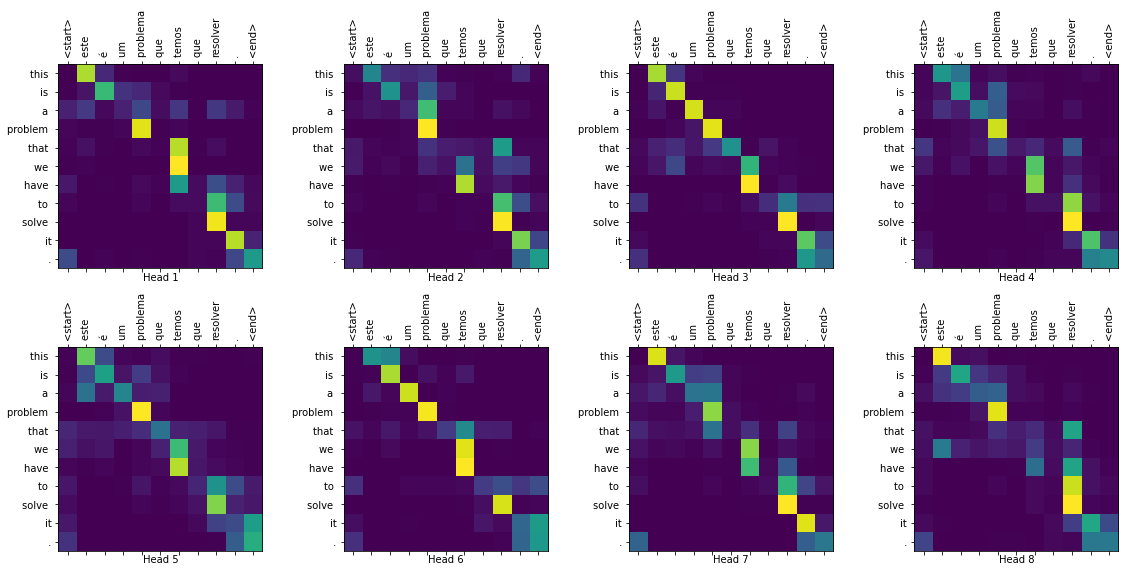

Real translation: this is a problem we have to solve .
pred shape (1, 1, 8089)
output shape (1, 1)
pred shape (1, 2, 8089)
output shape (1, 2)
pred shape (1, 3, 8089)
output shape (1, 3)
pred shape (1, 4, 8089)
output shape (1, 4)
pred shape (1, 5, 8089)
output shape (1, 5)
pred shape (1, 6, 8089)
output shape (1, 6)
pred shape (1, 7, 8089)
output shape (1, 7)
pred shape (1, 8, 8089)
output shape (1, 8)
pred shape (1, 9, 8089)
output shape (1, 9)
Input: os meus vizinhos ouviram sobre esta ideia.
Predicted translation: my neighbors heard about this idea .


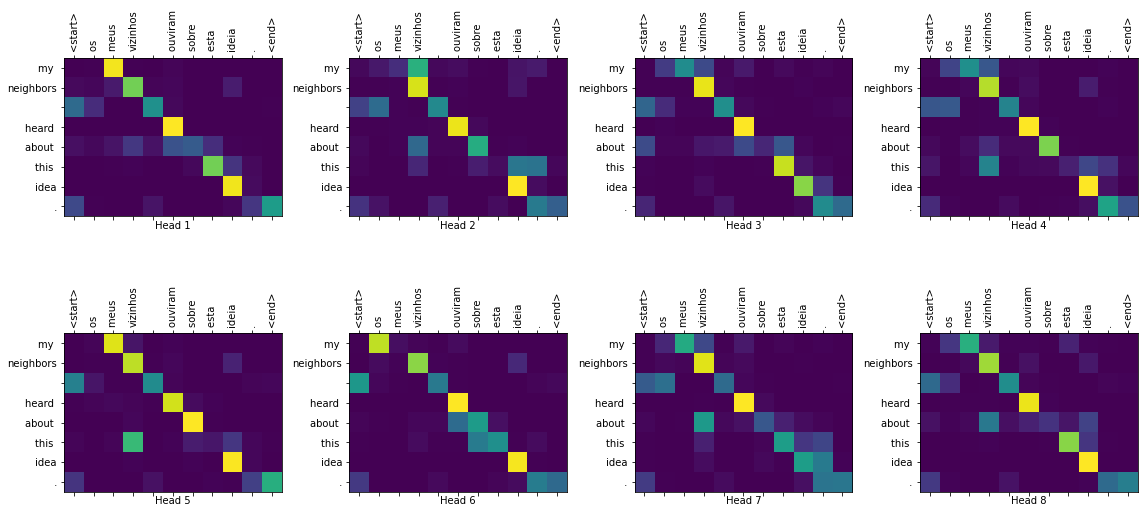

Real translation: and my neighboring homes heard about this idea .
pred shape (1, 1, 8089)
output shape (1, 1)
pred shape (1, 2, 8089)
output shape (1, 2)
pred shape (1, 3, 8089)
output shape (1, 3)
pred shape (1, 4, 8089)
output shape (1, 4)
pred shape (1, 5, 8089)
output shape (1, 5)
pred shape (1, 6, 8089)
output shape (1, 6)
pred shape (1, 7, 8089)
output shape (1, 7)
pred shape (1, 8, 8089)
output shape (1, 8)
pred shape (1, 9, 8089)
output shape (1, 9)
pred shape (1, 10, 8089)
output shape (1, 10)
pred shape (1, 11, 8089)
output shape (1, 11)
pred shape (1, 12, 8089)
output shape (1, 12)
pred shape (1, 13, 8089)
output shape (1, 13)
pred shape (1, 14, 8089)
output shape (1, 14)
pred shape (1, 15, 8089)
output shape (1, 15)
pred shape (1, 16, 8089)
output shape (1, 16)
pred shape (1, 17, 8089)
output shape (1, 17)
pred shape (1, 18, 8089)
output shape (1, 18)
pred shape (1, 19, 8089)
output shape (1, 19)
pred shape (1, 20, 8089)
output shape (1, 20)
pred shape (1, 21, 8089)
output

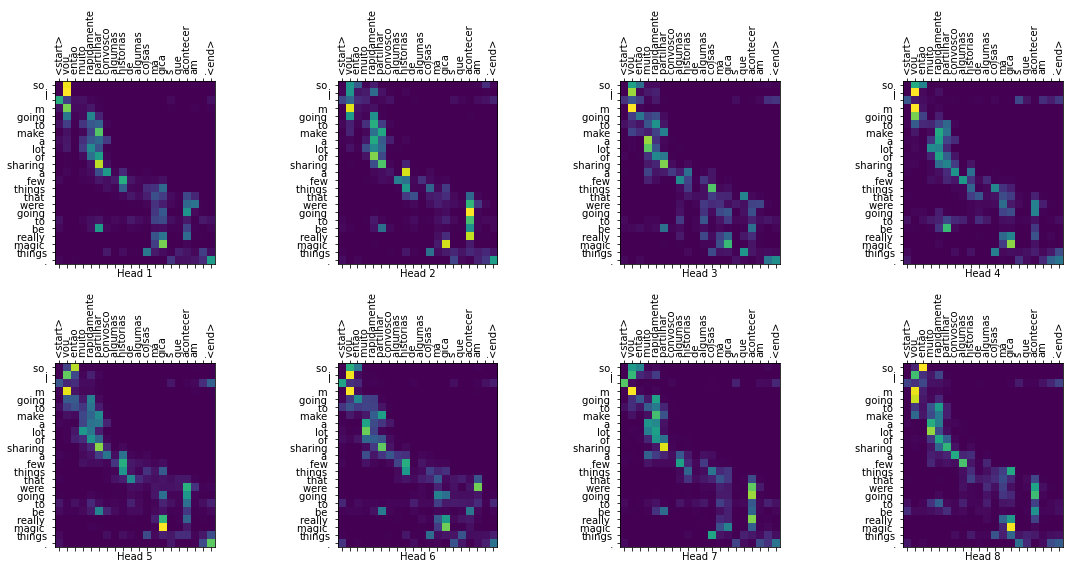

Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .
pred shape (1, 1, 8089)
output shape (1, 1)
pred shape (1, 2, 8089)
output shape (1, 2)
pred shape (1, 3, 8089)
output shape (1, 3)
pred shape (1, 4, 8089)
output shape (1, 4)
pred shape (1, 5, 8089)
output shape (1, 5)
pred shape (1, 6, 8089)
output shape (1, 6)
pred shape (1, 7, 8089)
output shape (1, 7)
pred shape (1, 8, 8089)
output shape (1, 8)
pred shape (1, 9, 8089)
output shape (1, 9)
pred shape (1, 10, 8089)
output shape (1, 10)
Input: este é o primeiro livro que eu fiz.
Predicted translation: this is the first book that i did .


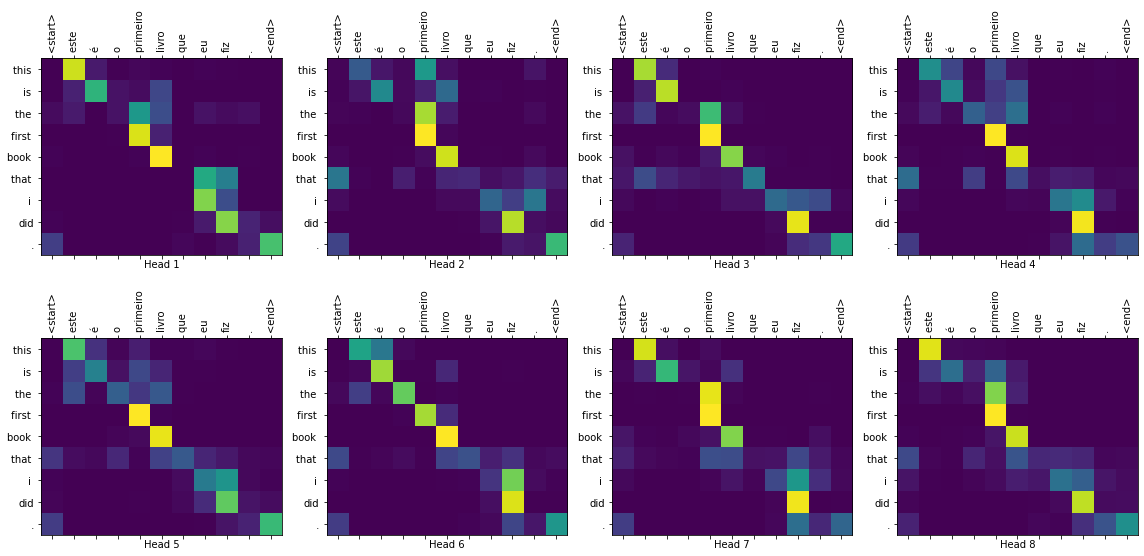

Real translation: this is the first book i've ever done.


In [20]:
translate("este é um problema que temos que resolver.", plot=4)
print ("Real translation: this is a problem we have to solve .")

translate("os meus vizinhos ouviram sobre esta ideia.", plot=4)
print ("Real translation: and my neighboring homes heard about this idea .")

translate("vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.", plot=4)
print ("Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .")

translate("este é o primeiro livro que eu fiz.", plot=4)
print ("Real translation: this is the first book i've ever done.")